In [1]:
import torch
import matplotlib.pyplot as plt

from models.cnep import CNEP
from data.data_generators import *

torch.set_float32_matmul_precision('high')

def get_free_gpu():
    gpu_util = []
    for i in range(torch.cuda.device_count()):
        torch.cuda.set_device(i)  # Switch GPU
#        gpu_util.append((i, torch.cuda.memory_stats()['reserved_bytes.all.current'] / (1024 ** 2)))
        gpu_util.append((i, torch.cuda.utilization()))
    gpu_util.sort(key=lambda x: x[1])
    return gpu_util[0][0]

if torch.cuda.is_available():
    available_gpu = get_free_gpu()
    if available_gpu == 0:
        device = torch.device("cuda:0")
    else:
        device = torch.device(f"cuda:{available_gpu}")
else:
    device = torch.device("cpu")

print("Device :", device)

Device : cuda:0


In [2]:
# Hyperparameters
batch_size = 32
n_max, m_max = 6, 6

t_steps = 200
num_demos = 128
num_classes = 4
num_indiv = num_demos//num_classes  # number of demos per class
noise_clip = 0.0
dx, dy = 1, 1

num_val = 32
num_val_indiv = num_val//num_classes

colors = ['r', 'g', 'b', 'm']

X: torch.Size([128, 200, 1]) Y: torch.Size([128, 200, 1]) VX: torch.Size([32, 200, 1]) VY: torch.Size([32, 200, 1])


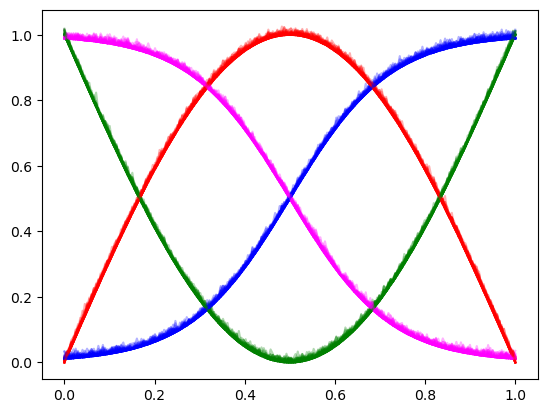

In [3]:
# Generating the data
x = torch.linspace(0, 1, 200).repeat(num_indiv, 1)
y = torch.zeros(num_demos, t_steps, dy)

vx = torch.linspace(0, 1, 200).repeat(num_val_indiv, 1)
vy = torch.zeros(num_val, t_steps, dy)

generator_functions = [generate_sin, generate_cos, generate_cx_sigm, generate_reverse_cx_sigm]

for i in range(num_classes):
    noise = torch.clamp(torch.randn(x.shape)*1e-4**0.5, min=0) - noise_clip
    y[i*num_indiv:(i+1)*num_indiv] = torch.unsqueeze(generator_functions[i](x) + noise, 2)
    noise = torch.clamp(torch.randn(vx.shape)*1e-4**0.5, min=0) - noise_clip
    vy[i*num_val_indiv:(i+1)*num_val_indiv] = torch.unsqueeze(generator_functions[i](vx) + noise, 2)

x = torch.unsqueeze(x.repeat(num_classes, 1), 2)  # since dx = 1
vx = torch.unsqueeze(vx.repeat(num_classes, 1), 2)
print("X:", x.shape, "Y:", y.shape, "VX:", vx.shape, "VY:", vy.shape)

for i in range(num_indiv):
    plt.plot(x[i, :, 0], y[i, :, 0], 'r', alpha=0.3)
    plt.plot(x[i+num_indiv, :, 0], y[i+num_indiv, :, 0], 'g', alpha=0.3)
    plt.plot(x[i+2*num_indiv, :, 0], y[i+2*num_indiv, :, 0], 'b', alpha=0.3)
    plt.plot(x[i+3*num_indiv, :, 0], y[i+3*num_indiv, :, 0], 'magenta', alpha=0.3)
plt.show()

x, y = x.to(device), y.to(device)

In [4]:
obs = torch.zeros((batch_size, n_max, dx+dy), dtype=torch.float32, device=device)
tar_x = torch.zeros((batch_size, m_max, dx), dtype=torch.float32, device=device)
tar_y = torch.zeros((batch_size, m_max, dy), dtype=torch.float32, device=device)
obs_mask = torch.zeros((batch_size, n_max), dtype=torch.bool, device=device)
tar_mask = torch.zeros((batch_size, m_max), dtype=torch.bool, device=device)

def prepare_masked_batch(t: list, traj_ids: list):
    obs.fill_(0)
    tar_x.fill_(0)
    tar_y.fill_(0)
    obs_mask.fill_(False)
    tar_mask.fill_(False)

    for i, traj_id in enumerate(traj_ids):
        traj = t[traj_id]

        n = torch.randint(1, n_max, (1,)).item()
        m = torch.randint(1, m_max, (1,)).item()

        permuted_ids = torch.randperm(t_steps)
        n_ids = permuted_ids[:n]
        m_ids = permuted_ids[n:n+m]
        
        obs[i, :n, :dx] = traj[n_ids]
        obs[i, :n, dx:] = (n_ids/t_steps).unsqueeze(1)
        obs_mask[i, :n] = True
        
        tar_x[i, :m] = traj[m_ids]
        tar_y[i, :m] = (m_ids/t_steps).unsqueeze(1)
        tar_mask[i, :m] = True

val_obs = torch.zeros((batch_size, n_max, dx+dy), dtype=torch.float32, device=device)
val_tar_x = torch.zeros((batch_size, t_steps, dx), dtype=torch.float32, device=device)
val_tar_y = torch.zeros((batch_size, t_steps, dy), dtype=torch.float32, device=device)
val_obs_mask = torch.zeros((batch_size, n_max), dtype=torch.bool, device=device)

def prepare_masked_val_batch(t: list, traj_ids: list):
    val_obs.fill_(0)
    val_tar_x.fill_(0)
    val_tar_y.fill_(0)
    val_obs_mask.fill_(False)

    for i, traj_id in enumerate(traj_ids):
        traj = t[traj_id]

        n = torch.randint(1, n_max, (1,)).item()

        permuted_ids = torch.randperm(t_steps)
        n_ids = permuted_ids[:n]
        m_ids = torch.arange(t_steps)
        
        val_obs[i, :n, :dx] = traj[n_ids]
        val_obs[i, :n, dx:] = (n_ids/t_steps).unsqueeze(1)
        val_obs_mask[i, :n] = True
        
        val_tar_x[i] = traj[m_ids]
        val_tar_y[i] = (m_ids/t_steps).unsqueeze(1)

In [5]:
import time

def model_train():
    # run = wandb.init()
    # nll_coeff = wandb.config.nll_coeff
    # other_loss_coeff = wandb.config.other_loss_coeff

    model = CNEP(1, 1, 6, 6, [128, 128, 128], num_decoders=4, decoder_hidden_dims=[128, 128, 128], batch_size=batch_size, scale_coefs=True).to(device)
    optimizer = torch.optim.Adam(lr=1e-4, params=model.parameters())

    file_name = int(time.time())

    epochs = 1_500_000
    epoch_iter = num_demos//batch_size  # number of batches per epoch (e.g. 100//32 = 3)
    v_epoch_iter = num_val//batch_size  # number of batches per validation (e.g. 100//32 = 3)
    avg_loss = 0

    val_per_epoch = 1000
    min_val_error = 1000000

    mse_loss = torch.nn.MSELoss()

    for epoch in range(epochs):
        epoch_loss = 0

        traj_ids = torch.randperm(x.shape[0])[:batch_size*epoch_iter].chunk(epoch_iter)  # [:batch_size*epoch_iter] because nof_trajectories may be indivisible by batch_size

        for i in range(epoch_iter):
            optimizer.zero_grad()
            prepare_masked_batch(x, traj_ids[i])
            torch.autograd.set_detect_anomaly(True)
            pred, gate = model(obs, tar_x, obs_mask)
            loss, nll = model.loss(pred, gate, tar_y, tar_mask)
            loss.backward()
            optimizer.step()

            epoch_loss += nll.item()

        if epoch % val_per_epoch == 0:
            with torch.no_grad():
                v_traj_ids = torch.randperm(vx.shape[0])[:batch_size*v_epoch_iter].chunk(v_epoch_iter)
                
                val_epoch_err = 0

                for j in range(v_epoch_iter):
                    prepare_masked_val_batch(vx, v_traj_ids[j])
                    p, g = model(val_obs, val_tar_x, val_obs_mask)
                    dec_id = torch.argmax(g.squeeze(1), dim=-1)
                    vp_means = p[dec_id, torch.arange(batch_size), :, :dy]
                    val_epoch_err += mse_loss(vp_means, val_tar_y).item()

                if val_epoch_err < min_val_error:
                    min_val_error = val_epoch_err
                    print(f'New best: {min_val_error}')
                    torch.save(model.state_dict(), f'saved_models/wtacnp_synth_{file_name}.pt')

        avg_loss += epoch_loss

        if epoch % 100 == 0:
            print("Epoch: {}, Loss: {}".format(epoch, avg_loss/100))
            avg_loss = 0

In [6]:
model_train()

New best: 0.3170870840549469
Epoch: 0, Loss: 0.024690332412719725
Epoch: 100, Loss: -2.4513040256057868
Epoch: 200, Loss: -12.071495911031962
Epoch: 300, Loss: -13.762822594046593
Epoch: 400, Loss: -14.996154035925866
Epoch: 500, Loss: -14.354745261669159
Epoch: 600, Loss: -16.027153805494308
Epoch: 700, Loss: -13.238712769150734
Epoch: 800, Loss: -13.856750338673592
Epoch: 900, Loss: -14.947204568386077
New best: 1.9227006475830422e-07
Epoch: 1000, Loss: -15.310103200227022
Epoch: 1100, Loss: -16.42003773331642
Epoch: 1200, Loss: -16.548766746520997
Epoch: 1300, Loss: -13.472772986888886
Epoch: 1400, Loss: -16.760206696540116
Epoch: 1500, Loss: -15.121107676811516
Epoch: 1600, Loss: -16.99849509179592
Epoch: 1700, Loss: -15.018031885623932
Epoch: 1800, Loss: -17.116322848796845
Epoch: 1900, Loss: -16.546393889188767
New best: 9.654641530687513e-08
Epoch: 2000, Loss: -15.898731758594513
Epoch: 2100, Loss: -14.96726350903511
Epoch: 2200, Loss: -17.13362059354782
Epoch: 2300, Loss: -15.3

KeyboardInterrupt: 

In [ ]:
def get_validation_batch(o_ids=[0, -1]):
    obs = torch.cat((vx[:, o_ids, :], vy[:, o_ids, :]), dim=-1)
    tar = vx[:, torch.arange(t_steps)]
    tar_val= vy[:, torch.arange(t_steps)]

    return obs, tar, tar_val


# Testing the best model

model = WTA_CNP(1, 1, 6, 6, [128, 128, 256], 4, [256, 128, 128], batch_size)
model.load_state_dict(torch.load(f'saved_models/wtacnp_synth_1703250812.pt'))
model.eval()

o, t, tr = get_validation_batch([15])

with torch.no_grad():
    p, g = model(o, t)

p, g = p.cpu().numpy(), g.cpu()
t, tr = t.cpu().numpy(), tr.cpu().numpy()

for i in range(batch_size):
    dec_id = torch.argmax(g[i, :, :]).item()
    print(dec_id)
    plt.plot(range(t_steps), p[dec_id, i, :, 0], colors[dec_id], alpha=0.3)

# for i in range(4):
#     plt.plot(range(t_steps), p[i, 6, :, 0], colors[i], alpha=0.3)

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

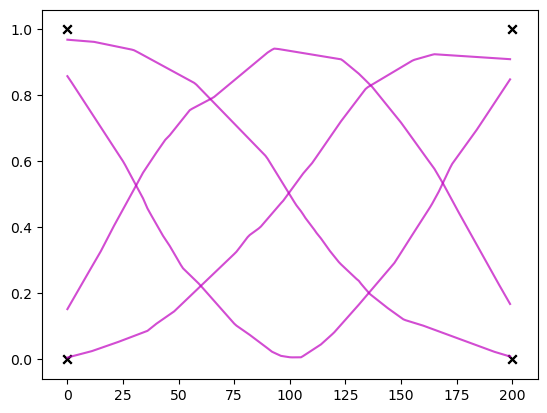

In [ ]:
### TESTING

def generate_test_batch(n=4):
    obs = torch.zeros(n, 2, 2)
    obs[0] = torch.tensor([[0, 0], [1, 0]])
    obs[1] = torch.tensor([[0, 0], [1, 1]])
    obs[2] = torch.tensor([[0, 1], [1, 0]])
    obs[3] = torch.tensor([[0, 1], [1, 1]])
    tar = vx[:4, torch.arange(t_steps)]

    return obs, tar


model = WTA_CNP(1, 1, 10, 10, [128, 128, 128], num_decoders=4, decoder_hidden_dims=[128, 128], batch_size=4)
model.load_state_dict(torch.load(f'saved_models/wtacnp_synth_1688469358.pt'))
model.eval()

o, t = generate_test_batch()

# print(o)

with torch.no_grad():
    p, g = model(o, t)

p, g = p.cpu().numpy(), g.cpu()

for i in range(4):

    # print(o[i, 0, 0], o[i, 0, 1], o[i, 1, 0], o[i, 1, 1])

    dec_id = torch.argmax(g[i, :, :]).item()
    plt.plot(range(t_steps), p[dec_id, i, :, 0], colors[dec_id], alpha=0.7)

    plt.scatter(o[i, 0, 0]*200, o[i, 0, 1], color='k', marker='x')
    plt.scatter(o[i, 1, 0]*200, o[i, 1, 1], color='k', marker='x')

for i in range(32):
    plt.plot(range(t_steps), tr[i, :, 0].cpu().numpy(), 'k', alpha=0.1, linestyle='dashed')

plt.show()

In [ ]:
# pytorch_total_params = sum(p.numel() for p in model.parameters())
# print(pytorch_total_params)
# pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print(pytorch_total_params)

166662
166662
